In [14]:
#Importing libraries

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam

from subprocess import check_output
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [15]:
#Base input image data

img_height = 30
img_width = 30
channels = 3
image_shape = (img_height, img_width, channels)

In [16]:
#Verifing that the training images are already normalized (values between 0 and 1)

imread('.//data//train//0//00000_00000_00000.png')

array([[[0.29411766, 0.30588236, 0.3137255 ],
        [0.2901961 , 0.29803923, 0.30588236],
        [0.3372549 , 0.34117648, 0.32941177],
        ...,
        [0.26666668, 0.29411766, 0.29411766],
        [0.25490198, 0.27058825, 0.26666668],
        [0.25882354, 0.2627451 , 0.25882354]],

       [[0.3254902 , 0.32941177, 0.3372549 ],
        [0.3137255 , 0.3137255 , 0.32156864],
        [0.3529412 , 0.34901962, 0.32941177],
        ...,
        [0.28627452, 0.3019608 , 0.30588236],
        [0.29803923, 0.30588236, 0.29411766],
        [0.3137255 , 0.3137255 , 0.30588236]],

       [[0.30588236, 0.30588236, 0.3137255 ],
        [0.3372549 , 0.33333334, 0.3372549 ],
        [0.3647059 , 0.3529412 , 0.35686275],
        ...,
        [0.28235295, 0.2901961 , 0.28235295],
        [0.28627452, 0.2901961 , 0.27058825],
        [0.30588236, 0.30588236, 0.2901961 ]],

       ...,

       [[0.52156866, 0.5254902 , 0.54509807],
        [0.47843137, 0.49803922, 0.5176471 ],
        [0.4392157 , 0

In [17]:
#Creating the image generator from the training folder

train_path = './/data//train'

image_gen = ImageDataGenerator(shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=False, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               validation_split=0.15 # set validation split
                              )

In [18]:
#Creating the model

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=image_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(43, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)         

In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [21]:
batch_size = 16

In [22]:
#Creating the training and validation generator (validation is both testing and validation)

train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    subset='training') # set as training data

validation_generator = image_gen.flow_from_directory(
    train_path, # same directory as training data
    target_size=image_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary',
    subset='validation') # set as validation data

Found 33337 images belonging to 43 classes.
Found 5872 images belonging to 43 classes.


In [23]:
#Training the model

results = model.fit_generator(train_generator,epochs=20,
                              validation_data=validation_generator,
                             callbacks=[early_stop])

Epoch 1/20
2084/2084 [==============================] - 62s 30ms/step - loss: 3.2993 - accuracy: 0.3643 - val_loss: 0.4946 - val_accuracy: 0.8769
Epoch 2/20
2084/2084 [==============================] - 75s 36ms/step - loss: 0.6638 - accuracy: 0.8047 - val_loss: 0.3435 - val_accuracy: 0.9126
Epoch 3/20
2084/2084 [==============================] - 107s 52ms/step - loss: 0.4983 - accuracy: 0.8611 - val_loss: 0.3140 - val_accuracy: 0.9143
Epoch 4/20
2084/2084 [==============================] - 112s 54ms/step - loss: 0.4259 - accuracy: 0.8871 - val_loss: 0.4054 - val_accuracy: 0.8980
Epoch 5/20
2084/2084 [==============================] - 116s 56ms/step - loss: 0.4821 - accuracy: 0.8746 - val_loss: 0.4115 - val_accuracy: 0.8987


In [24]:
#Saving the model

model.save('traffic_sign_classifier_89acc.h5')

In [25]:
score = model.evaluate(validation_generator, verbose=0)

In [26]:
'Test accuracy : {:.4f}'.format(score[1])

'Test accuracy : 0.8975'

In [27]:
#Saving history of the model as a dictionary

history_dict = results.history

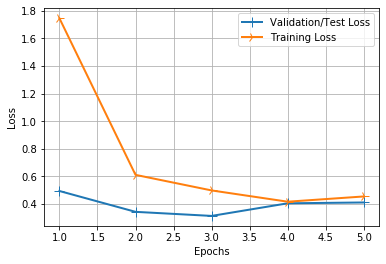

In [28]:
#Plotting loss and validation loss against epochs

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = "Validation/Test Loss")
line2 = plt.plot(epochs, loss_values, label = "Training Loss")
plt.setp(line1, linewidth=2.0, marker= '+', markersize = 10)
plt.setp(line2, linewidth=2.0, marker= '4', markersize = 10)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

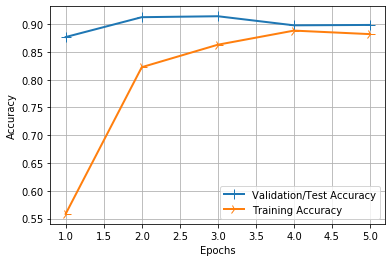

In [29]:
#Plotting acc and validation acc against epochs

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = "Validation/Test Accuracy")
line2 = plt.plot(epochs, acc_values, label = "Training Accuracy")
plt.setp(line1, linewidth=2.0, marker= '+', markersize = 10)
plt.setp(line2, linewidth=2.0, marker= '4', markersize = 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Classes dictionary

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
#Inputting the image to be predicted

img_path = './/data//train//27//00027_00000_00028.png'

my_image = image.load_img(img_path, target_size=image_shape)
my_image = image.img_to_array(my_image)

my_image = my_image / 255 # Transforming into array and normalizing it
my_image = np.expand_dims(my_image, axis=0) #Expanding from (30, 30, 3) to (1, 30, 30, 3)

my_image.shape

In [ ]:
#Loading the model

model = load_model('traffic_sign_classifier1.h5')

In [ ]:
#Predicting the class

pred_class = np.argmax(model.predict(my_image), axis=-1)
classes[pred_class[0]]